# TM10007 Assignment Group 5

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/annawalstra/tm10007_Group5.git
!pip install simpleITK

     |████████████████████████████████| 42.5MB 97kB/s 


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

The number of spamples: 855
The number of columns: 268


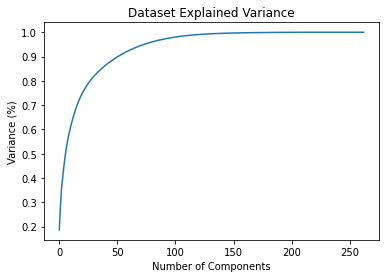

Nr. of components:73


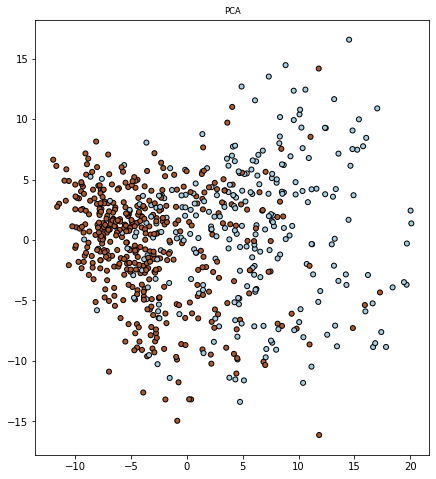

In [34]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel

# Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data
data = load_data()
print(f'The number of spamples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating X and Y 
X = data.loc[:, data.columns != 'label']
Y = data['label']

# Preprocessing: deleting features with only zeros
X = X.loc[:, (X != 0).any(axis=0)]
# print(f'The number of spamples: {len(X.index)}')
# print(f'The number of columns: {len(X.columns)}')

# Binarize Y labels
y_bin = preprocessing.label_binarize(Y, ['CN','AD'])
y_bin = [i[0] for i in y_bin]
#print(y_bin)

# Split the dataset in train and test part
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_bin, test_size=0.2, stratify=y_bin)


# Scale the data 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Fitting the PCA algorithm with our Data
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

# Perform a PCA
var = np.cumsum(pca.explained_variance_ratio_) 
n_components = np.where(var > 0.95)[0][0]
print(f"Nr. of components:{n_components}")


# Perform a PCA
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# # Use the selectfrommodel module: L1 Select all features with a weight above the median.
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Lasso, RidgeClassifier
# selector = SelectFromModel(estimator=Lasso(alpha=10**(-5)), threshold='median')
# selector.fit(X_train_scaled, Y_train)
# n_original = X_train_scaled.shape[1]
# X_train_L1 = selector.transform(X_train_scaled)
# X_test_L1 = selector.transform(X_test_scaled)
# n_selected = X_train_L1.shape[1]
# print(f"Selected {n_selected} from {n_original} features.")

#Plot first feature PCA
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("PCA", fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=Y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)


# #Plot first feature L1 selection
#fig = plt.figure(figsize=(24,8))
#ax = fig.add_subplot(132)
#ax.set_title("L1", fontsize='small')
#ax.scatter(X_train_L1[:, 0], X_train_L1[:, 1], marker='o', c=Y_train,
        #     s=25, edgecolor='k', cmap=plt.cm.Paired)


# Crossvalidation for parameter tuning
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

In [0]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

## KNN Classifier

Vraag: met grid_search.best_estimator_ krijg ik als het beste resultaat k=33, maar als ik k=25 invul krijg ik een hoger resultaat voor test en train. 

vgm snap ik dit nu wel...Soms grid_search.best_estimator_ ander resultaat voor beste k dan clf.n_neigbors


Best leaf_size: 28
Best p: 2
Best n_neighbors: 13
KNeighborsClassifier(algorithm='auto', leaf_size=28, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       269
           1       0.83      0.90      0.86       415

    accuracy                           0.83       684
   macro avg       0.83      0.81      0.81       684
weighted avg       0.83      0.83      0.82       684

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        67
           1       0.80      0.84      0.82       104

    accuracy                           0.77       171
   macro avg       0.76      0.75      0.76       171
weighted avg       0.77      0.77      0.77       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

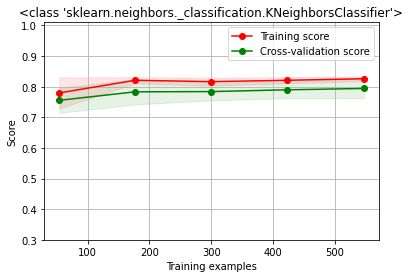

In [15]:
# # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# # Specify the classifier
# knn = neighbors.KNeighborsClassifier()
# parameters = {"n_neighbors": list(range(1, 51, 2))}
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')
# grid_search.fit(X_train_pca, Y_train)
# # Show the complete results of the cross validation
# display(pd.DataFrame(grid_search.cv_results_))


# # # Fit kNN
# # Get resulting classifier
# print(grid_search.best_estimator_)
# #print(f'Best classifier: k={clf.n_neighbors}')
# clf = neighbors.KNeighborsClassifier(n_neighbors=21)
# clf.fit(X_train_pca, Y_train)
# score_train = clf.score(X_train_pca, Y_train)
# score_test = clf.score(X_test_pca, Y_test)

# # Get the accuracy
# y_pred = clf.predict(X_train_pca)
# acc_train=metrics.accuracy_score(Y_train, y_pred)
# y_pred = clf.predict(X_test_pca)
# acc_test=metrics.accuracy_score(Y_test, y_pred)

# # Print result
# print(f"Training result: {score_train}")
# print(f"Test result: {score_test}")
# print(f"Accuracy:")
# print(f"Training result: {acc_train}")
# print(f"Test result: {acc_test}")


#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,50))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)
#Create new KNN object
knn_2 = neighbors.KNeighborsClassifier()
#Use GridSearch
#cv_10fold = model_selection.StratifiedKFold(n_splits=10)
random_search = model_selection.RandomizedSearchCV(knn_2, hyperparameters, cv=cv_10fold)

#Fit the model
best_model = random_search.fit(X_train_pca,Y_train)
clf = random_search.best_estimator_

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print(clf)

# Test train
from sklearn.metrics import classification_report
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))
# Test model

y_pred = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred))

#Learning curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
plt.show()
title = str(type(clf))
#ax = fig.add_subplot(7, 3, 1)
ax = fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)

## KNN with Crossvalidation

De k wisselt heel erg met elke CV, conclusie: erg afhankelijk van training data 
wat beste k geeft, dus ....??


Best classifier: k=12
Best classifier: k=11
Best classifier: k=43
Best classifier: k=30
Best classifier: k=42
Best classifier: k=28
Best classifier: k=30
Best classifier: k=10
Best classifier: k=25
Best classifier: k=46
Best classifier: k=19
Best classifier: k=33
Best classifier: k=44
Best classifier: k=19
Best classifier: k=10
Best classifier: k=31
Best classifier: k=22
Best classifier: k=18
Best classifier: k=33
Best classifier: k=46


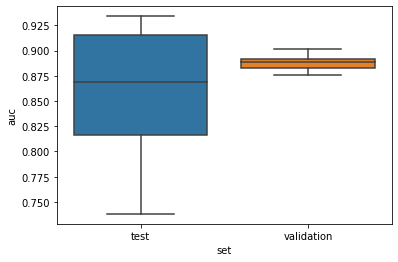

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        67
           1       0.78      0.88      0.83       104

    accuracy                           0.78       171
   macro avg       0.78      0.75      0.76       171
weighted avg       0.78      0.78      0.77       171

0.7777777777777778


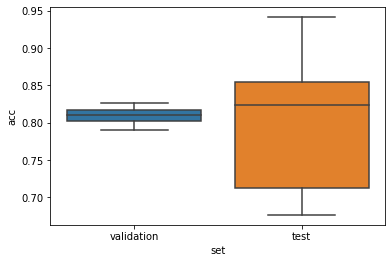

In [20]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
results_acc = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_testKNN = X_train_pca[test_index]
    y_testKNN = np.array(Y_train)[test_index]

    #List Hyperparameters that we want to tune.
    leaf_size = list(range(1,50))
    n_neighbors = list(range(1,50))
    p=[1,2]
    hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)
    #Create new KNN object
    knn_2 = neighbors.KNeighborsClassifier()
    #Use RandomSearch
    #cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    random_search = model_selection.RandomizedSearchCV(knn_2, hyperparameters, cv=cv_10fold)

    #Fit the model
    best_model = random_search.fit(X_validation, y_validation)
    clf = random_search.best_estimator_
    
    # # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # # Same as above
    # parameters = {"n_neighbors": list(range(1, 26, 2))}
    # knn = neighbors.KNeighborsClassifier()
    # cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    # grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    # grid_search.fit(X_validation, y_validation)
    
    # # Get resulting classifier
    # clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)

    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_testKNN)
    scores = probabilities[:, 1]

    # Get the accuracy
    y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(y_validation, y_pred)
    results_acc.append({'acc': accuracy,'set': 'validation'})
    y_pred = clf.predict(X_testKNN)
    accuracy = metrics.accuracy_score(y_testKNN, y_pred)
    results_acc.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(y_testKNN, scores)
    results.append({'auc': auc,'k': clf.n_neighbors,'set': 'test'})       
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({'auc': auc_validation,'k': clf.n_neighbors,'set': 'validation'})
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results)
plt.show()
results_acc = pd.DataFrame(results_acc)
seaborn.boxplot(y='acc', x='set', data=results_acc)

optimal_n = int(np.median(best_n_neighbors))
#print(f"The optimal N={optimal_n}")


from sklearn.metrics import classification_report
print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))

# Support Vector Machine (SVM) Classifier 



In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
 
  
# defining parameter range 
param_grid = {'C': [0.01, 0.5, 1],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.5, 1],
              'degree': [1, 3, 5]}  

# For now: 3 options for kernels implemented: linear rbf and poly
# Other options on kernels:
# - sampler, for example: first use RBF sampler, then linear kernel
# - manually constructed kernel function?
# - precomputed kernel
# - sigmoid kernel

#grid = svm.SVC(probability=True)
grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold) 
  
# fitting the model for grid search 
best_model = grid.fit(X_train_pca, Y_train) 
clf = grid.best_estimator_


print(grid.best_params_)
print(grid.best_estimator_)

print('Best slack parameter C:', grid.best_estimator_.get_params()['C'])
print('Best gamma:', grid.best_estimator_.get_params()['gamma'])
print('Best kernel:', grid.best_estimator_.get_params()['kernel'])
print('Best coef0:', grid.best_estimator_.get_params()['coef0'])
print('Best degree:', grid.best_estimator_.get_params()['degree'])

# Classification report (training data)
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

#Classification report (test data)
y_pred_test = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred_test))



{'kernel': 'linear', 'gamma': 0.1, 'degree': 5, 'coef0': 1, 'C': 0.5}
SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=5, gamma=0.1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Best slack parameter C: 0.5
Best gamma: 0.1
Best kernel: linear
Best coef0: 1
Best degree: 5
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       269
           1       0.87      0.91      0.89       415

    accuracy                           0.86       684
   macro avg       0.86      0.85      0.85       684
weighted avg       0.86      0.86      0.86       684

              precision    recall  f1-score   support

           0       0.74      0.75      0.74        67
           1       0.83      0.83      0.83       104

    accuracy                           0.80       171
   macro avg       0.79      0.79      0.79   

# SVM with cross-validation

ERROR! Session/line number was not unique in database. History logging moved to new session 61
Best slack parameter: C=0.01
Best gamma: gamma=1
Best kernel: kernel=linear
Best coef0: coef0=0.5
Best degree: degree=5
Best slack parameter: C=1
Best gamma: gamma=0.1
Best kernel: kernel=linear
Best coef0: coef0=0.5
Best degree: degree=1
Best slack parameter: C=0.01
Best gamma: gamma=0.1
Best kernel: kernel=linear
Best coef0: coef0=1
Best degree: degree=1
Best slack parameter: C=0.01
Best gamma: gamma=1
Best kernel: kernel=linear
Best coef0: coef0=0.5
Best degree: degree=3
Best slack parameter: C=0.5
Best gamma: gamma=0.01
Best kernel: kernel=poly
Best coef0: coef0=0.01
Best degree: degree=1
Best slack parameter: C=0.01
Best gamma: gamma=0.1
Best kernel: kernel=linear
Best coef0: coef0=0.5
Best degree: degree=3
Best slack parameter: C=0.01
Best gamma: gamma=0.1
Best kernel: kernel=poly
Best coef0: coef0=0.5
Best degree: degree=1
Best slack parameter: C=0.5
Best gamma: gamma=0.1
Best kernel: 

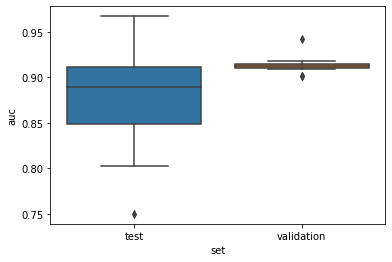

The optimal C=0
The optimal gamma=0


NameError: ignored

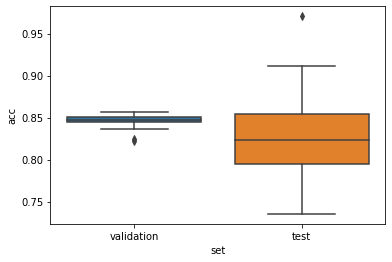

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
results_acc = []
best_C = []
best_gamma = []
best_kernel = []
best_coef0 = []
best_degree = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test_SVM = X_train_pca[test_index]
    Y_test_SVM = np.array(Y_train)[test_index]
    
    
    # Same as above
    param_grid = {'C': [0.01, 0.5, 1],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.5, 1],
              'degree': [1, 3, 5]}
    grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold, scoring='roc_auc')  
    best_model = grid.fit(X_validation, Y_validation)

    
    # Get resulting classifier
    clf = grid.best_estimator_
    print(f'Best slack parameter: C={clf.C}')
    print(f'Best gamma: gamma={clf.gamma}')
    print(f'Best kernel: kernel={clf.kernel}')
    print(f'Best coef0: coef0={clf.coef0}')
    print(f'Best degree: degree={clf.degree}')

    best_C.append(clf.C)
    best_gamma.append(clf.gamma)
    best_kernel.append(clf.kernel)
    best_coef0.append(clf.coef0)
    best_degree.append(clf.degree)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test_SVM)
    scores = probabilities[:, 1]

    # Get the accuracy
    Y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf.predict(X_test_SVM)
    accuracy = metrics.accuracy_score(Y_test_SVM, Y_pred)
    results_acc.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_test_SVM, scores)
    results.append({'auc': auc,'C': clf.C, 'gamma': clf.gamma, 
                    'kernel': clf.kernel, 'coef0': clf.coef0, 
                    'degree': clf.degree,'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'C': clf.C,
        'gamma': clf.gamma,
        'kernel': clf.kernel,
        'coef0': clf.coef0,
        'degree': clf.degree,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results)
plt.show()
results_acc = pd.DataFrame(results_acc)
seaborn.boxplot(y='acc', x='set', data=results_acc)

optimal_C = int(np.mean(best_C))
print(f"The optimal C={optimal_C}")
optimal_gamma = int(np.mean(best_gamma))
print(f"The optimal gamma={optimal_gamma}")
#optimal_kernel = most_frequent(best_kernel)
#print(f"The optimal kernel={optimal_kernel}")
optimal_coef0 = int(np.mean(best_coef0))
print(f"The optimal coef0={optimal_coef0}")
optimal_degree = int(np.mean(best_degree))
print(f"The optimal degree={optimal_degree}")

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))

**Random Forrest Classifier**

The Random Forrest Classifier has 19 different hyperparameters:
- n_estimators: number of trees (to much --> overfitting)
- criterion: How to measure the quality of a split (gini) (tree-specific)
- max_depth: depth of the tree
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: number of samples required to be at a node
- min_weight_fraction_leaf: sum total of the weigths at a node.
- max_features: number of features to consider
- max_leaf_nodes: 
- min_impurity_decrease: node will split if impurity decreases with this value
- min_impurity_split: A node will split if its impurity is above the threshold, otherwise it is a leaf
- bootstrap: use or not (T/F) (To improve accuracy by creating samples)
if T --> max_samples: number of samples to train each base estimator
- oob_score: use out-of-bag samples
- n_jobs: 
- random_state: 
- verbose:
- warm_start:
- class_weight: If one class is more important
- ccp_alpha: x

--> Misschien toevoegen: een tijd segment om te kijken of het niet te lang duurt




In [0]:
#Hyperparameters tuning:
n_tree = [10,25,50,100]  # n_estimators
boot = ['True','False']  # Bootstrapping
criterion = ['gini','entropy'] # measure of quality
max_depth = [range(5, 16)] # Depth of the tree
min_samples_split = [range(2,7)] # prevends overfitting
min_samples_leaf = [1,2] # prevends overfitting
classweight = [{0: 1, 1: 0.001},{0: 1, 1: 1},
               {0: 1, 1: 10},{0: 1, 1: 100}]


clsfs = [n_tree, boot, criterion, max_depth, min_samples_split, 
         min_samples_leaf, classweight]


# Y_test = validation set, niet de test set
for clf in clsfs:
  for hype_par in clf:
    for X, Y in zip(Xtrain,Ytrain):
      clf.fit(X, Y)
      y_pred_train = clf.predict(X_train_pca)
      acc_train = metrics.accuracy_score(Y_train, y_pred)
      y_pred_test = clf.predict(X_test_pca)
      acc_test = metrics.accuracy_score(Y_test, y_pred)
      acc_test_clsfs.append(acc_test)
    maxpos = acc.index(max(acc_test_clsfs))
  # hier moet nog dat het die plek van deze classifier is 

clsfs_final = [RandomForestClassifier(n_estimators = n_tree(n_tree[maxpos]))]

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        clf.fit(X, Y)
        ax = fig.add_subplot(7, 3, num + 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
        colorplot(clf, ax, X[:, 0], X[:, 1])
        y_pred = clf.predict(X)
        t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
        ax.set_title(t)
        num += 1

False
